# Телеком - Поиск клиента с неоптимальными тарифами

Общая информация, цель и задачи иследования:

- Цель - найти клиентов которые переплачивают по своим тарифным планам
- Задача - предложить таким клиентам более оптимальные тарифные планы чтобы они не ушли к другим операторам

Импортируем библиотеки:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats as st  

Выгрузка данных и общей информации по ним:




In [2]:
clients = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_clients.csv')
dataset = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_dataset.csv')

In [3]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [4]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


в таблице clients пропусков нет,  
но нужно заменить тип данных 'date_start' на datetime

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [6]:
dataset.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


в таблице dataset есть пропуски в колонке 'operator_id' и 'internal',

также нужно заменить тип данных в колонках 'date' на datetime, 'internal' на bool, 'operator_id' на int.

# 1. Предобработка данных:

- проверка на пропуски
- замена типов данных
- проверка на дубликаты

проверим явные дубликаты

In [7]:
print('кол-во явных дубликатов в clients=', clients.duplicated().sum())

кол-во явных дубликатов в clients= 0


In [8]:
print('кол-во явных дубликатов в dataset=', dataset.duplicated().sum())

кол-во явных дубликатов в dataset= 4900


In [9]:
#удалим явные дубликаты в dataset
dataset = dataset.drop_duplicates()

1.2 Заменим типы данных

In [10]:
clients['date_start'] = pd.to_datetime(clients['date_start'])
dataset['date'] = pd.to_datetime(dataset['date']).dt.tz_localize(None)
dataset['operator_id'] = dataset['operator_id'].astype('Int64')
dataset['internal'] = dataset['internal'].astype('bool')

посчитаем кол-во пропусков в dataset

In [11]:
dataset.isna().sum()

user_id                   0
date                      0
direction                 0
internal                  0
operator_id            7456
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [12]:
dataset['user_id'].nunique()

307

In [13]:
#есть кейсы без операторов с ненулевой продолжительностью вызова
dataset[dataset['operator_id'].isna() & (dataset['call_duration'] > 0)]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
698,166399,2019-08-12,in,False,<NA>,False,1,10,55
704,166399,2019-09-02,in,False,<NA>,False,1,68,115
4089,166503,2019-09-26,out,False,<NA>,False,1,213,220
4136,166503,2019-10-09,in,False,<NA>,False,1,374,405
4198,166503,2019-10-21,out,True,<NA>,False,2,382,397
...,...,...,...,...,...,...,...,...,...
50930,168252,2019-11-28,in,True,<NA>,False,2,265,274
50946,168252,2019-11-28,in,False,<NA>,False,45,23765,23897
50955,168252,2019-11-28,out,False,<NA>,False,22,11904,12211
50956,168252,2019-11-28,out,True,<NA>,False,1,159,168


In [14]:
dataset['month'] =  dataset['date'].dt.to_period('M')

In [15]:
clients.groupby(by='user_id').agg({'tariff_plan':'nunique'}).query('tariff_plan > 1')

,tariff_plan
user_id,


у всех клиентов был один тарифный план

посмотрим что за пропуски в operator_id

In [16]:
dataset[dataset['operator_id'].isna()].head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month
0,166377,2019-08-04,in,False,<NA>,True,2,0,4,2019-08
7,166377,2019-08-05,in,False,<NA>,True,6,0,35,2019-08
9,166377,2019-08-06,in,False,<NA>,True,4,0,62,2019-08
17,166377,2019-08-07,in,False,<NA>,True,2,0,24,2019-08
27,166377,2019-08-12,in,False,<NA>,True,2,0,34,2019-08


In [17]:
dataset[dataset['operator_id'].isna()].groupby(by='is_missed_call').agg({'is_missed_call': 'value_counts'})

,,is_missed_call
is_missed_call,is_missed_call,
False,False,113
True,True,7343


In [18]:
dataset[dataset['operator_id'].isna()].groupby(by='internal').agg({'internal': 'value_counts'})

,,internal
internal,internal,
False,False,7078
True,True,378


большинство пропусков в operator_id это пропушеные внешние звонки

переведем секунды в минуты в колонках call_duration total_call_duration разделим на 60

In [19]:
dataset['call_duration'] = np.ceil(dataset['call_duration']/60)
dataset['total_call_duration'] = np.ceil(dataset['total_call_duration']/60)

вывод:

- поменяли формат данных date_start на datetime, date на datetime, operator_id на Int64, internal на bool
- выяснили что большинство пропусков в operator_id это пропушеные звонки

- перевели секунды в минуты (тк в дальнейшем заметим что время представлено скорее всего в секундах тк очень большие числа и в минутах такое не возможно)

# Исcледовательская часть:

Проверим за какой промежуток времени у нас есть данные

In [20]:
print('Дата первой записи:', dataset['date'].min())
print('Дата последней записи:', dataset['date'].max())

Дата первой записи: 2019-08-02 00:00:00
Дата последней записи: 2019-11-28 00:00:00


In [21]:
print('уникальных клиентов =', dataset['user_id'].nunique())

уникальных клиентов = 307


In [22]:
(dataset
        .query('total_call_duration > 0')
        .groupby(by='user_id')['date'].max()
).describe()

C:\Users\Ounly mini\AppData\Local\Temp\ipykernel_11736\2804735001.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  ).describe()


count                     306
unique                     51
top       2019-11-28 00:00:00
freq                      166
first     2019-08-07 00:00:00
last      2019-11-28 00:00:00
Name: date, dtype: object

In [23]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [24]:
#проверяем кол-во уникальных user_id , что клиенты не повторяются
clients['user_id'].nunique(), clients.shape[0]

(732, 732)

видно что не все зарегистрировавшиеся клиенты были активны в иследовании

проверим когда клиенты регистрировались

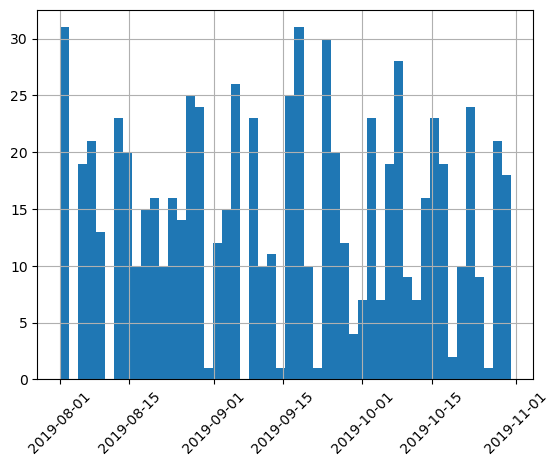

In [25]:
(clients
        .groupby(by='user_id')['date_start'].max()
        .hist(bins=50)
)
plt.xticks(rotation=45)
plt.show()

видим что клиенты равномерно подключалтсь к тарифам (нет такого что они пришли в последние месяцы)

проверим последнюю дату совершения звонков по каждому клиенту 

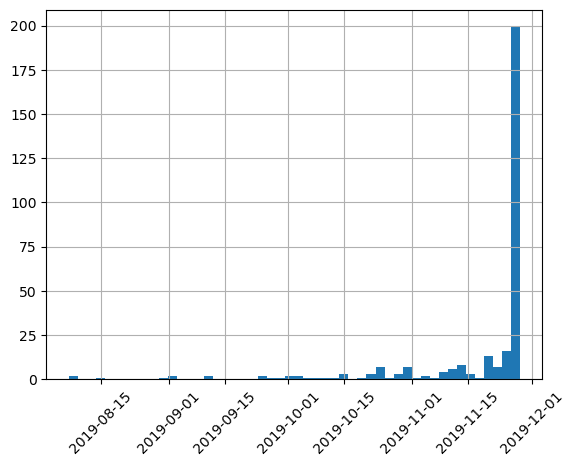

In [26]:
(dataset
        .query('total_call_duration > 0')
        .groupby(by='user_id')['date'].max()
        .hist(bins=50)
)
plt.xticks(rotation=45)
plt.show()

видим , что большая часть клиентов были активны в последний месяц, предпологаем что клиенты которые не совершали звонков в последний месяц уже не пользуются услугами данного оператора связи.
    всё равно мы возьмём их выборку потому что нужно проверить оптимальный был у них тарифы чтобы предложить им новый тариф и возможно они вернутся

In [27]:
# средняя длительность одного звонка
dataset['one_call'] =  dataset['call_duration']/dataset['calls_count']

In [28]:
#проверка
#dataset[dataset['user_id'] == 166582].sort_values(by='one_call')

In [29]:
#dataset[dataset['call_duration'] > 0]['one_call'].describe()
dataset.query('call_duration > 0')['one_call'].describe()

count    27828.000000
mean         2.163951
std          2.454007
min          0.090909
25%          1.000000
50%          1.500000
75%          2.400000
max         60.000000
Name: one_call, dtype: float64

средняя длительность звонка = 2.16 минут
медиана длительности звонка = 1.5 минут
также есть аномальные звонки с длительность по 60 мин

<Axes: >

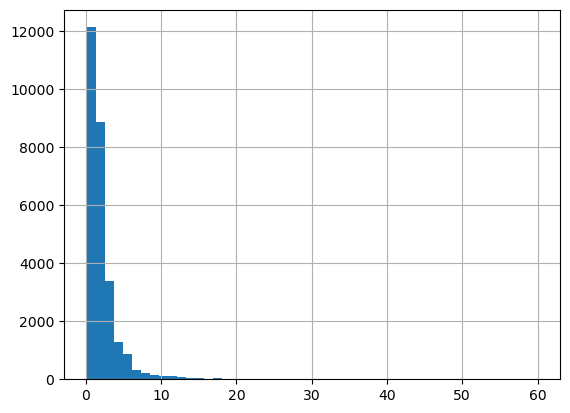

In [30]:
dataset.query('call_duration > 0')['one_call'].hist(bins=50)

In [31]:
#переделать! группируем по операторам и по датам
operator_calls = dataset.groupby(['user_id', 'date', 'operator_id'], as_index=False)\
    .agg({'calls_count':'sum', 'call_duration':'sum'}).sort_values(by='call_duration')
operator_calls.head()

,user_id,date,operator_id,calls_count,call_duration
3554,166660,2019-08-26,887802,9,0.0
5975,166916,2019-10-25,928284,2,0.0
16275,168047,2019-10-23,937604,2,0.0
704,166406,2019-10-06,879898,1,0.0
5988,166916,2019-10-30,906392,2,0.0


In [32]:
#видим аномальные значения продолжительности звонка, проверим также кол-во звонков
operator_calls['call_duration'].describe()

count    19647.000000
mean        36.305390
std         98.416172
min          0.000000
25%          3.000000
50%         12.000000
75%         38.000000
max       2418.000000
Name: call_duration, dtype: float64

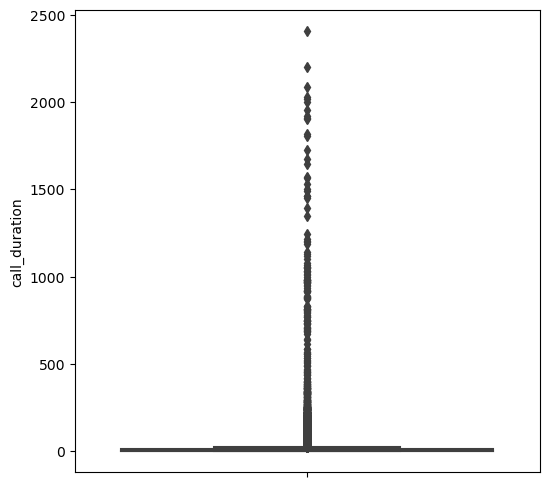

In [33]:
plt.figure(figsize=(6,6))
ax = sns.boxplot(data=dataset, y='call_duration')
#ax.set_ylim([0, 700]) 
plt.show()

медиана звонков в день у каждого оператора  = 36
но есть аномальные значения у некоторых операторов = 2000 звонкам в день, теоретически такое возвомжно если никто не поднимал трубку

отсортируем по длительности звонков 

In [34]:
operator_calls.sort_values(by = 'call_duration', ascending = False)

,user_id,date,operator_id,calls_count,call_duration
2352,166582,2019-09-25,885876,2039,2418.0
2354,166582,2019-09-26,885876,1603,2287.0
2326,166582,2019-09-12,885876,1104,2113.0
2320,166582,2019-09-09,885876,1700,2044.0
2366,166582,2019-10-02,885876,1570,2036.0
...,...,...,...,...,...
1788,166520,2019-09-17,892028,4,0.0
18837,168336,2019-11-20,966158,1,0.0
11893,167471,2019-10-25,944644,1,0.0
18830,168336,2019-11-19,948758,1,0.0


видим неправдоподобную длительность звонков для одного оператора,
возьмем 12 ч как длительность рабочего дня, (например график 2/2 по 12 ч ) 720 минут

посчитаем сколько клиентов у которых операторы совершали аномально длинные звонки в день

In [35]:
operator_calls.query('call_duration > 720')['user_id'].nunique()

1

найдем этого клиента и сколько у него операторов

In [36]:
(operator_calls
            .query('call_duration > 720')
            .groupby(by='user_id')['operator_id'].nunique()
        )

user_id
166582    3
Name: operator_id, dtype: int64

получается у клиента 166582 всего 3 оператора    

посчитаем длительность звонков в месяц у клиента 166582

In [37]:
dataset.query('user_id == 166582').groupby('month')['call_duration'].sum()

month
2019-08    23249.0
2019-09    61826.0
2019-10    56030.0
2019-11     1310.0
Freq: M, Name: call_duration, dtype: float64

In [38]:
clients.query('user_id == 166582')

,user_id,tariff_plan,date_start
50,166582,A,2019-08-09


нашли одного клиента 166582 Который скрывает своих операторов(Используют один аккаунт оператора сразу для нескольких своих подчинённых) скорее всего у него гораздо больше операторов но платят он только за троих. 
Ну ему вряд ли можно предложить какой-то более оптимальный тариф потому что он итак использует максимальный тариф А. можно только предложить создать новый тариф. Можем предложить дополнительный контроль со стороны сотового оператора за количеством операторов.

# считаем прибыль 

по формуле: 
- абоненская плата = Ежемесячная плата за тариф + число операторов * Дополнительная ежемесячная плата за
каждого оператора
- цена сверх лимита =(количество исходящих минут внутри сети - Исходящие минуты внутри сети, включённые в тариф) * Цена сверх лимита + (длительность Исходящих звонков, кроме внутренних * цену исходящих звонков)
- абоненская плата + цена сверх лимита

посчитаем количество операторов у каждого клиента

In [39]:
#все клиенты по месяцам с уникальными операторами
users = dataset.groupby(['user_id', 'month'])['operator_id'].nunique().reset_index()
#переименуем колонки
users.columns = ['user_id', 'month', 'operator_cnt']
users.head()

,user_id,month,operator_cnt
0,166377,2019-08,5
1,166377,2019-09,4
2,166377,2019-10,5
3,166377,2019-11,4
4,166391,2019-08,2


In [40]:
#operators = dataset.groupby(['user_id', 'month'])['operator_id'].nunique().reset_index()
#operators

посчитаем длительность внешних исходящих звонков за месяц у каждого клиента

In [41]:
month_data_false = (dataset
    .query('direction == "out" and internal == False')
    .groupby(by=['user_id', 'month'])['call_duration'].sum()
    .reset_index()
)
month_data_false.columns = ['user_id', 'month', 'internal_false_min']
month_data_false

,user_id,month,internal_false_min
0,166377,2019-08,1102.0
1,166377,2019-09,1455.0
2,166377,2019-10,1385.0
3,166377,2019-11,1327.0
4,166405,2019-08,750.0
...,...,...,...
502,168481,2019-11,8.0
503,168500,2019-11,0.0
504,168601,2019-11,415.0
505,168603,2019-11,17.0


посмотрим распределение длительности звонков за месяц у клиентов

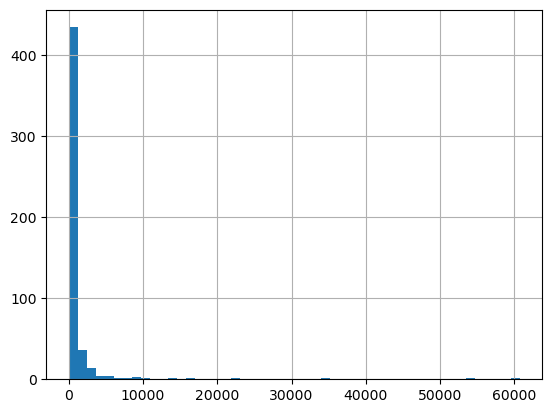

In [42]:
month_data_false['internal_false_min'].hist(bins=50)
plt.show()

в основном совершали мало исходящих внутрених звонков но есть некоторые которые звонят по долгу в месяц

посчитаем длительность внутренних исходящих звонков за месяц у каждого клиента

In [43]:
month_data_true = (dataset
    .query('direction == "out" and internal == True')
    .groupby(by=['user_id', 'month'])['call_duration'].sum()
    .reset_index()
)
month_data_true.columns = ['user_id', 'month', 'internal_true_min']
month_data_true

,user_id,month,internal_true_min
0,166377,2019-08,1.0
1,166377,2019-09,0.0
2,166377,2019-10,1.0
3,166377,2019-11,2.0
4,166391,2019-08,0.0
...,...,...,...
270,168416,2019-10,0.0
271,168416,2019-11,0.0
272,168500,2019-11,1.0
273,168601,2019-11,0.0


соеденим таблицы клиентов с количеством операторов и внешних исходящих звонков 

In [44]:
dt = users.merge(month_data_true, how = 'left', on=['user_id', 'month'])
dt

,user_id,month,operator_cnt,internal_true_min
0,166377,2019-08,5,1.0
1,166377,2019-09,4,0.0
2,166377,2019-10,5,1.0
3,166377,2019-11,4,2.0
4,166391,2019-08,2,0.0
...,...,...,...,...
787,168583,2019-11,2,NaN
788,168598,2019-11,1,NaN
789,168601,2019-11,2,0.0
790,168603,2019-11,1,NaN


соеденим таблицы с внутреними исходящими звонками

In [45]:
dt1 = dt.merge(month_data_false, how='outer', on=['user_id', 'month'])
dt1

,user_id,month,operator_cnt,internal_true_min,internal_false_min
0,166377,2019-08,5,1.0,1102.0
1,166377,2019-09,4,0.0,1455.0
2,166377,2019-10,5,1.0,1385.0
3,166377,2019-11,4,2.0,1327.0
4,166391,2019-08,2,0.0,NaN
...,...,...,...,...,...
787,168583,2019-11,2,NaN,NaN
788,168598,2019-11,1,NaN,NaN
789,168601,2019-11,2,0.0,415.0
790,168603,2019-11,1,NaN,17.0


добавим какой тарифный план у каждого клиента

In [46]:
dt2 = dt1.merge(clients[['user_id', 'tariff_plan']], how='left', on='user_id')
dt2

,user_id,month,operator_cnt,internal_true_min,internal_false_min,tariff_plan
0,166377,2019-08,5,1.0,1102.0,B
1,166377,2019-09,4,0.0,1455.0,B
2,166377,2019-10,5,1.0,1385.0,B
3,166377,2019-11,4,2.0,1327.0,B
4,166391,2019-08,2,0.0,NaN,C
...,...,...,...,...,...,...
787,168583,2019-11,2,NaN,NaN,B
788,168598,2019-11,1,NaN,NaN,C
789,168601,2019-11,2,0.0,415.0,C
790,168603,2019-11,1,NaN,17.0,B


добавим информацию по тарифным планам

In [47]:
limit_minutes = {'A': 2000, 'B': 500, 'C': 0 }

In [48]:
monthly_pay = {'A': 4000, 'B': 2000, 'C': 1000}

In [49]:
operators_pay = {'A': 50, 'B': 150, 'C': 300}

In [50]:
overpay = {'A': 0.1, 'B': 0.15, 'C': 0.3}

In [51]:
out_calls = {'A': 0.3, 'B': 0.5, 'C': 0.7}

In [52]:
dt2['limit_minutes'] = dt2['tariff_plan'].map(limit_minutes)

In [53]:
dt2['monthly_pay'] = dt2['tariff_plan'].map(monthly_pay)

In [54]:
dt2['operators_pay'] = dt2['tariff_plan'].map(operators_pay)

In [55]:
dt2['overpay'] = dt2['tariff_plan'].map(overpay)

In [56]:
dt2['out_calls'] = dt2['tariff_plan'].map(out_calls)

In [57]:
dt2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 792 entries, 0 to 791
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype    
---  ------              --------------  -----    
 0   user_id             792 non-null    int64    
 1   month               792 non-null    period[M]
 2   operator_cnt        792 non-null    int64    
 3   internal_true_min   275 non-null    float64  
 4   internal_false_min  507 non-null    float64  
 5   tariff_plan         792 non-null    object   
 6   limit_minutes       792 non-null    int64    
 7   monthly_pay         792 non-null    int64    
 8   operators_pay       792 non-null    int64    
 9   overpay             792 non-null    float64  
 10  out_calls           792 non-null    float64  
dtypes: float64(4), int64(5), object(1), period[M](1)
memory usage: 74.2+ KB


заменим пропуски internal_true_min и internal_false_min на 0

In [58]:
dt2[['internal_true_min', 'internal_false_min']] = dt2[['internal_true_min', 'internal_false_min']].fillna(0)

расчет абоненской платы по месяцам + плата за каждого оператора

In [59]:
dt2['monthly_fee'] = dt2['monthly_pay'] + (dt2['operator_cnt'] * dt2['operators_pay'])

расчет платы сверх предоставленных минут и исходящие внешние звонки в месяц

In [60]:
#функция для расчета сверх предоставленных минут и исходящих внешних звонков
def pay_calc(row):
    
    if row['internal_true_min'] > row['limit_minutes']:
            
        return (row['internal_true_min'] - row['limit_minutes']) * row['overpay'] + (row['internal_false_min'] * row['out_calls'])
    else:
        return (row['internal_false_min'] * row['out_calls'])

In [61]:
dt2['overpay_total'] = dt2.apply(pay_calc, axis = 1)

расчет общей платы в месяц

In [62]:
dt2['total_pay'] = dt2['monthly_fee'] + dt2['overpay_total']

In [63]:
#проверка вывода минимума из трех колонок
#dt2[['monthly_fee', 'overpay_total', 'total_pay']].min(axis=1)

общая информация по общей сумме за месяц

In [64]:
dt2['total_pay'].describe()

count      792.000000
mean      2488.171591
std       1862.424198
min       1000.000000
25%       1368.250000
50%       2150.000000
75%       2755.000000
max      22326.500000
Name: total_pay, dtype: float64

Прибыль за месяц по тарифам:

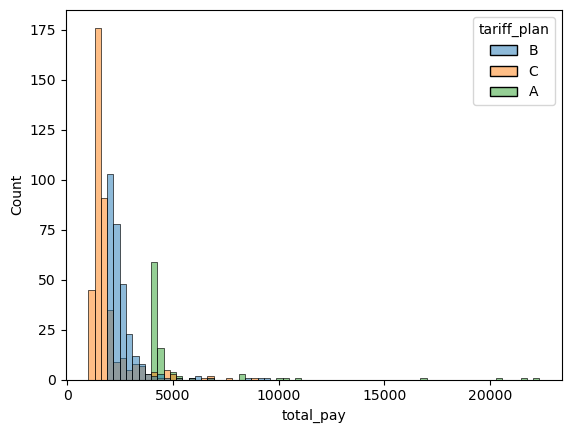

In [65]:
sns.histplot(data=dt2, x="total_pay", hue='tariff_plan')
plt.show()

# Ищем оптимальный тариф

информация о тарифах

In [66]:
tariff = (dt2.groupby('tariff_plan')
 .agg({'limit_minutes': 'min', 'monthly_pay': 'min', 'operators_pay': 'min' , 'overpay': 'min', 'out_calls': 'min'}))
tariff

,limit_minutes,monthly_pay,operators_pay,overpay,out_calls
tariff_plan,,,,,
A,2000,4000,50,0.10,0.3
B,500,2000,150,0.15,0.5
C,0,1000,300,0.30,0.7


In [67]:
# #tariff['tariff_plan'] == 'B'
# tariff.query('tariff_plan == "B"')['limit_minutes']['B']
# tariff.loc['B']['limit_minutes']

In [68]:
# функция расчитывает оплату по тарифу
def calc_all_tariffs(data, plan):
    
    res_a = []
    for index, row in data.iterrows():
        #print(row)
        if row['internal_true_min'] > tariff.query('tariff_plan == @plan')['limit_minutes'][plan]:
            result = tariff.loc[plan]['monthly_pay'] + (row['operator_cnt'] * tariff.loc[plan]['operators_pay']) +  (row['internal_true_min'] - row['limit_minutes']) * tariff.loc[plan]['overpay'] + row['internal_false_min'] * tariff.loc[plan]['out_calls']
            res_a.append(result)
        else:
            res_a.append(tariff.loc[plan]['monthly_pay'] + (row['operator_cnt'] * tariff.loc[plan]['operators_pay']) + row['internal_false_min'] * tariff.loc[plan]['out_calls'])
 
    return res_a

In [69]:
dt2['tariff_A'] = calc_all_tariffs(dt2, 'A')
dt2['tariff_B'] = calc_all_tariffs(dt2, 'B')
dt2['tariff_C'] = calc_all_tariffs(dt2, 'C')

In [70]:
#функция находит оптимальный тариф
def tariff_optimal(row):

    if row['tariff_A'] < row['tariff_B']:
        
        if row['tariff_A'] < row['tariff_C']:
            final = 'A'
        else:
            final = 'C'
    else:
        if row['tariff_B'] < row['tariff_C']:
            final = 'B'
        else:
            final = 'C'
    return final

In [71]:
dt2['tariff_optimal'] = dt2.apply(tariff_optimal, axis = 1)

добавим колонку где True это у клиента уже был оптимальный тариф, False - клиенту нужно предложить оптимальный тариф из колонки tariff_optimal

In [72]:
dt2['is_optimal'] = np.where(dt2['tariff_plan'] == dt2['tariff_optimal'], True, False)

находим минимальный тариф

In [73]:
dt2['optimal_pay'] = dt2[['tariff_A', 'tariff_B', 'tariff_C']].min(axis=1)

кол-во клиентов с оптимальными и неоптимальными тарифами

In [74]:
dt2.groupby(by='is_optimal')['user_id'].nunique()

is_optimal
False    157
True     169
Name: user_id, dtype: int64

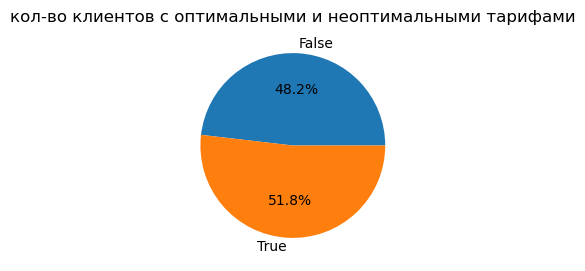

In [75]:
dt2.groupby(by='is_optimal')['user_id'].nunique().plot(kind = 'pie', autopct='%1.1f%%', figsize = (7, 3), ylabel='')
plt.title('кол-во клиентов с оптимальными и неоптимальными тарифами')
plt.show()

около половины пользователей с неоптимальными тарифами 

Посмотрим распределения по тарифам до и после перевода на оптимальные тарифы

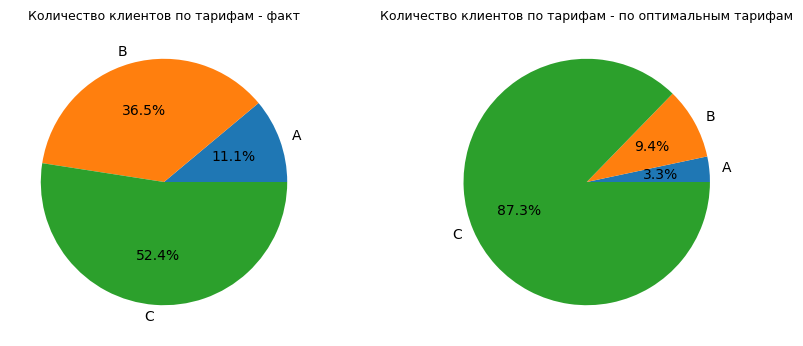

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
ax.set_ylabel('ylabel', fontsize=5)
dt2.groupby(['tariff_plan'])['user_id'].nunique().plot(kind = 'pie', autopct='%1.1f%%', ax = axes[0], title='Количество клиентов по тарифам - факт'
                                                       , ylabel='')
dt2.groupby('tariff_optimal')['user_id'].nunique().plot(kind = 'pie', autopct='%1.1f%%', ax = axes[1], title = 'Количество клиентов по тарифам - по оптимальным тарифам'
                                                        , ylabel='', figsize = (10, 4))

axes[0].title.set_size(9)
axes[1].title.set_size(9)
plt.show()

Делаем вывод, что доля пользователей с тарифами А и В значительно сократится в пользу тарифа С при переходе на оптимальные тарифы

In [77]:
dt3 = dt2[['user_id', 'month', 'total_pay', 'tariff_plan','tariff_optimal', 'is_optimal', 'optimal_pay']]
dt3.head()

,user_id,month,total_pay,tariff_plan,tariff_optimal,is_optimal,optimal_pay
0,166377,2019-08,3301.0,B,C,False,3121.7
1,166377,2019-09,3327.5,B,C,False,3218.5
2,166377,2019-10,3442.5,B,C,False,3319.8
3,166377,2019-11,3263.5,B,C,False,2979.5
4,166391,2019-08,1600.0,C,C,True,1600.0


- сравним фактическую прибыль и прибыль после перехода на оптимальные тарифы по месяцам и если клиеты с неоптимальными тарифами уйдут:

сделаем срез где не будет клиентов с неоптимальными тарифами

In [78]:
dt_witout = dt2.query('is_optimal == False')

In [79]:
#посчитаем прибыль без клиентов с неоптимальными тарифами
revenue_witout = dt_witout.groupby(by='month').agg({'total_pay': 'sum'})
revenue_witout.columns = ['rev_without']
revenue_witout = revenue_witout.reset_index()
revenue_witout

,month,rev_without
0,2019-08,131822.0
1,2019-09,272326.9
2,2019-10,381686.8
3,2019-11,378513.7


In [80]:
dif_pay = dt3.groupby(by='month').agg({'total_pay': 'sum', 'optimal_pay': 'sum'}).reset_index()
#dif_pay['dif_%'] = dif_pay['optimal_pay']/dif_pay['total_pay']-1
dif_pay

,month,total_pay,optimal_pay
0,2019-08,196841.8,147184.8
1,2019-09,435068.1,343251.1
2,2019-10,676594.3,547753.8
3,2019-11,662127.7,539930.8


прибыль компании если клиенты с неоптимальными тарифами уйдут:

In [81]:
#соединим две таблицы с прибылью
dif_pay = dif_pay.merge(revenue_witout,  how='left', on='month').set_index('month')
dif_pay

,total_pay,optimal_pay,rev_without
month,,,
2019-08,196841.8,147184.8,131822.0
2019-09,435068.1,343251.1,272326.9
2019-10,676594.3,547753.8,381686.8
2019-11,662127.7,539930.8,378513.7


In [82]:
dif_pay = dt3.groupby(by='month').agg({'total_pay': 'sum', 'optimal_pay': 'sum'})
dif_pay['dif_%'] = dif_pay['optimal_pay']/dif_pay['total_pay']-1
dif_pay

,total_pay,optimal_pay,dif_%
month,,,
2019-08,196841.8,147184.8,-0.252269
2019-09,435068.1,343251.1,-0.211041
2019-10,676594.3,547753.8,-0.190425
2019-11,662127.7,539930.8,-0.184552


прибыль компании по месяцам:

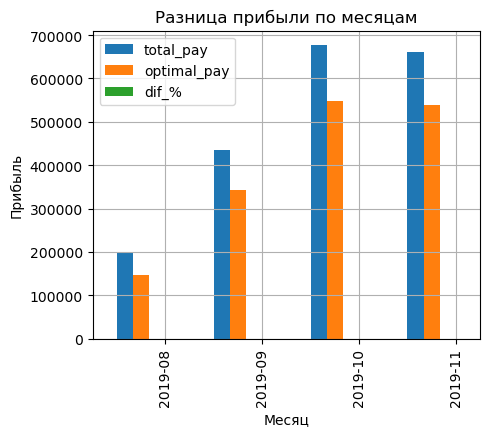

In [83]:
dif_pay.plot(kind='bar', figsize=(5,4), position=1, grid=True)
plt.title('Разница прибыли по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Прибыль')
plt.show()

In [84]:
print('фактическая прибыль =', dt3['total_pay'].sum())
print('прибыль после перехода на оптимальные тарифы =', dt3['optimal_pay'].sum())
print('прибыль если клиенты уйдут=', dt_witout['total_pay'].sum())

фактическая прибыль = 1970631.9
прибыль после перехода на оптимальные тарифы = 1578120.5
прибыль если клиенты уйдут= 1164349.4


если всех клиентов перевести на оптимальные тарифы прибыль компании уменьшится на 20-25%

если клиенты уйдут то прибыль сократится примерно на 40%

In [85]:
dt2.groupby(by=['tariff_plan','month']).agg({'total_pay': 'sum', 'optimal_pay':'sum'})

total_pay  optimal_pay
tariff_plan month                          
A           2019-08    52225.7      27949.8
            2019-09   103489.2      62517.8
            2019-10   179093.6     113915.0
            2019-11   157876.2      99782.3
B           2019-08    86773.0      61691.5
            2019-09   167900.0     122861.9
            2019-10   240474.0     181739.3
            2019-11   256285.1     196726.7
C           2019-08    57843.1      57543.5
            2019-09   163678.9     157871.4
            2019-10   257026.7     252099.5
            2019-11   247966.4     243421.8

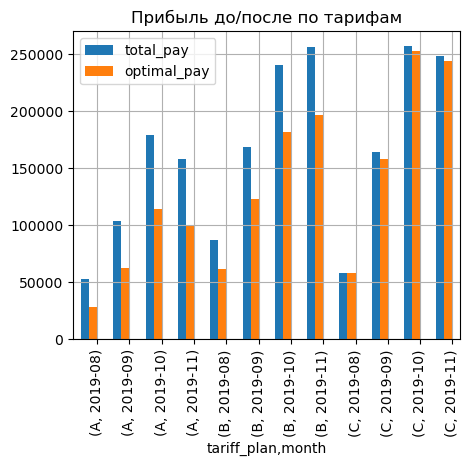

In [86]:
(dt2.groupby(by=['tariff_plan','month']).agg({'total_pay': 'sum', 'optimal_pay':'sum'})
   .plot(kind='bar', figsize=(5,4), position=1, grid=True, title = 'Прибыль до/после по тарифам')
)
plt.show()

если мы переведем клиентов на оптимальные тарифы прибыль уменьшится по тарифам А и В. по тарифу С прибыль не изменится хотя туда придут новые клиенты.

сколько в среднем платят клиенты каждого тарифа

In [87]:
dif_tariff_pay = dt2.groupby(by='tariff_plan').agg({'total_pay':'mean', 'optimal_pay':'mean'})

dif_tariff_pay['dif_%'] = dif_tariff_pay['optimal_pay']/dif_tariff_pay['total_pay']-1
dif_tariff_pay.columns = [['pay_before', 'optimal_pay', 'dif_%']]
dif_tariff_pay

,pay_before,optimal_pay,dif_%
tariff_plan,,,
A,5297.684946,3270.590323,-0.382638
B,2600.111073,1948.164014,-0.250738
C,1771.988049,1733.990732,-0.021443


переплата клиентов по тарифам:

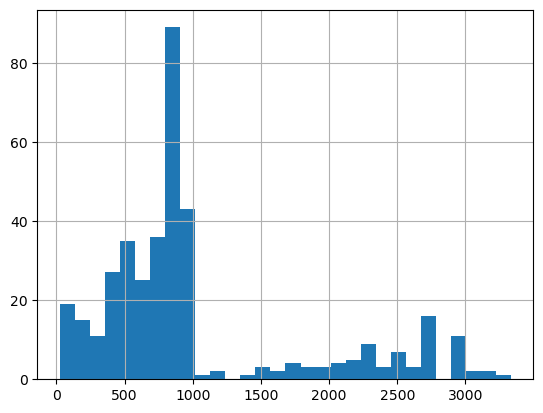

count     382.000000
mean     1027.516754
std       787.630227
min        26.600000
25%       548.500000
50%       842.500000
75%      1000.000000
max      3333.700000
dtype: float64

In [88]:
dt_hist = dt2.query('is_optimal == False')

(dt_hist['total_pay']-dt_hist['optimal_pay']).hist(bins=30)
plt.show()
(dt_hist['total_pay']-dt_hist['optimal_pay']).describe()

В среднем клиенты переплачивают 1027 рублей

Посмотрим на переплаты отдельно по каждому тарифу:

C:\Users\Ounly mini\AppData\Local\Temp\ipykernel_11736\1548535894.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_hist['pay_diff'] = dt_hist['total_pay']-dt_hist['optimal_pay']


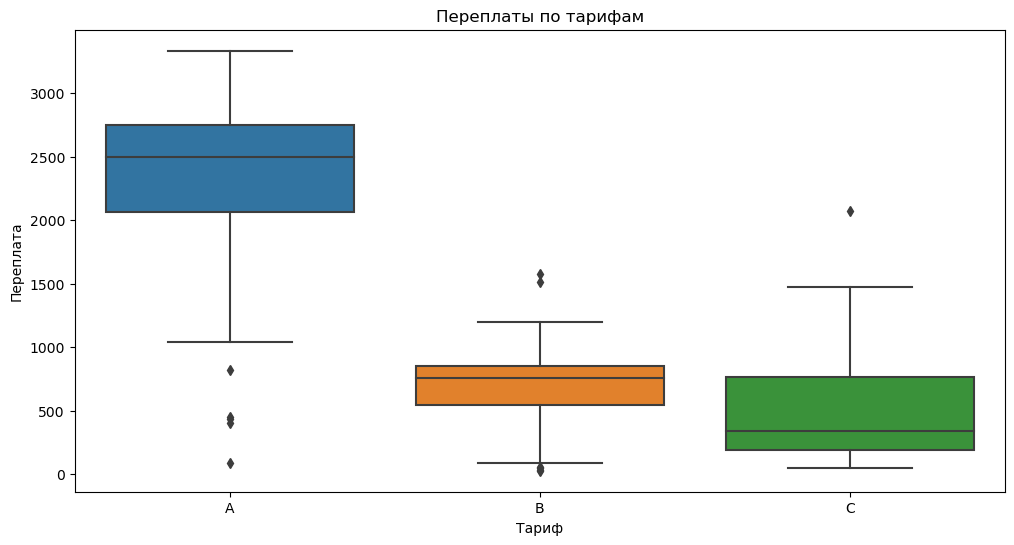

In [89]:
dt_hist['pay_diff'] = dt_hist['total_pay']-dt_hist['optimal_pay']
ranks = dt_hist.groupby("tariff_plan")['pay_diff'].mean().fillna(0).sort_values()[::-1].index
plt.figure(figsize=(12,6))
ax = sns.boxplot(data= dt_hist, x='tariff_plan', y='pay_diff', order = ranks)
#ax.set_ylim([3.5, 4.5]) 
plt.title('Переплаты по тарифам')
plt.xlabel('Тариф')
plt.ylabel('Переплата')
plt.show()

Переплата по тарифу А - медиана 2500руб. - что значительно больше, чем по другим тарифам

Логично предложить перейти на оптимальные тарифы тем клиентам, которые переплачивают больше всего.
Напишем функцию для исследования переплат.

In [90]:
users_by_overpay = dt_hist.groupby('user_id')['pay_diff'].sum().sort_values(ascending = False).reset_index()

В функции задаем границу - например, топ 10% переплативших и получаем размер потерь прибыли.

In [91]:
dt2['pay_diff'] = dt2['total_pay']-dt2['optimal_pay']
def top_percent(data, perc=0.3):
    return data.head(int(len(data)*(perc)))['user_id'].unique()

def calc_revenue(users_by_overpay, data, perc, ax):
    top_users = top_percent(users_by_overpay, perc)
    overpay = round(dt2.query('user_id in @top_users')['pay_diff'].mean())
    d = {'Категория': ['fact', 'optimal'], 'Прибыль': [data['total_pay'].sum(), data.query('user_id in @top_users')['optimal_pay'].sum() + data.query('user_id not in @top_users')['total_pay'].sum()]}
    df = pd.DataFrame(data=d).set_index('Категория')
    plot = df.plot(kind='bar', ax=axes[ax], title = str(perc * 100) + "% клиентов", xlabel = '', ylabel = 'Прибыль, млн.'
                   , ylim = ([1500000, 2000000]))
    #plt.ylim([1500000, 2000000])
    loss_perc = round((df.loc['optimal']['Прибыль']/df.loc['fact']['Прибыль'] - 1)* 100, 1)
    print("Предлагаем тариф " + str(perc * 100) + "% клиентов:", '\n', 'cредняя месячная переплата данных клиентов - ', overpay)
    print("Фактическая прибыль: ", round(df.loc['fact']['Прибыль']), "- оптимальная прибыль: ", round(df.loc['optimal']['Прибыль']))
    print("На оптимальный тариф перейдут " + str(len(top_users)) + " клиентов")
    print("Потери в прибыли составят: ", loss_perc, "%", "\n")





Предлагаем тариф 20.0% клиентов: 
 cредняя месячная переплата данных клиентов -  2037
Фактическая прибыль:  1970632 - оптимальная прибыль:  1771020
На оптимальный тариф перейдут 31 клиентов
Потери в прибыли составят:  -10.1 % 

Предлагаем тариф 40.0% клиентов: 
 cредняя месячная переплата данных клиентов -  1401
Фактическая прибыль:  1970632 - оптимальная прибыль:  1686266
На оптимальный тариф перейдут 62 клиентов
Потери в прибыли составят:  -14.4 % 



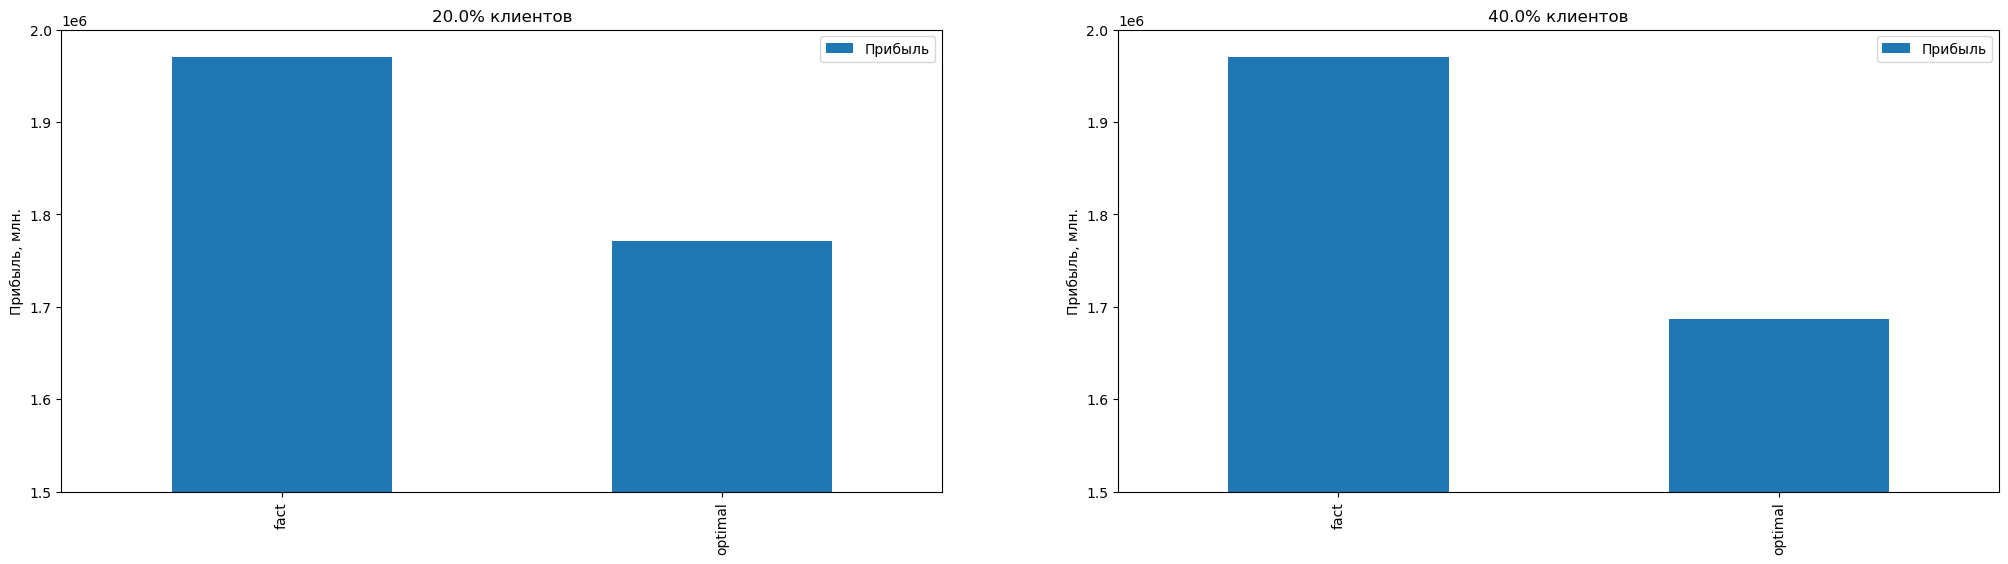

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(25,6))
calc_revenue(users_by_overpay, dt2, 0.2, 0)
calc_revenue(users_by_overpay, dt2, 0.4, 1)

Видим, что если мы предложим перейти на оптимальные тарифы топ 40% переплативших, то потери составят около 15% выручки, что меньше чем при уходе этих клиентов или переводе всех клиентов на оптимальные тарифы.

----

Гипотеза - большинство клиентов не используют внутрение звонки

распределение длительности внутрених исходящих звонков за каждый месяц по клиентам

In [93]:
dt2[['user_id', 'month', 'internal_true_min', 'tariff_plan']].sort_values(by='internal_true_min')

,user_id,month,internal_true_min,tariff_plan
365,167110,2019-09,0.0,B
429,167242,2019-11,0.0,C
430,167244,2019-09,0.0,C
431,167244,2019-10,0.0,C
683,168042,2019-10,0.0,C
...,...,...,...,...
466,167359,2019-10,385.0,B
692,168062,2019-11,560.0,A
699,168091,2019-11,664.0,B
255,166916,2019-11,1246.0,A


In [94]:
print(np.percentile(dt2['internal_true_min'], [95, 99]))

[ 44.45 301.41]


Не более 5% длитеьности звонков свыше 44 мин за месяц и не более 1% свыше 301 минут за месяц.
также 

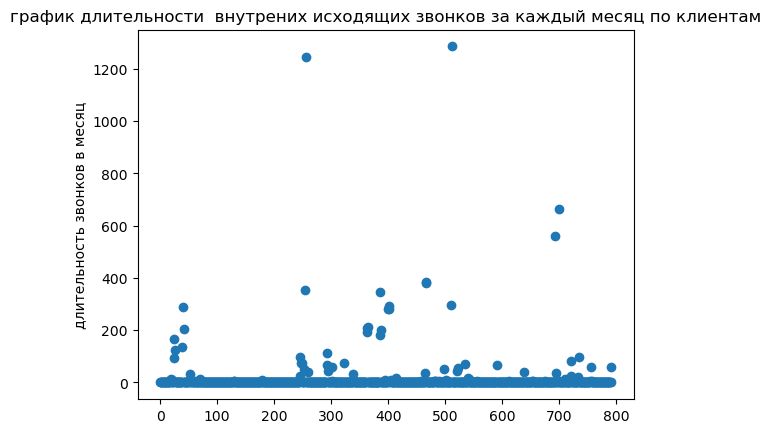

In [95]:
#Построим точечный график внутрених исходящих звонков за каждый месяц по клиентам
x_values = pd.Series(range(0,len(dt2)))

plt.scatter(x_values, dt2['internal_true_min'])

plt.ylabel('длительность звонков в месяц')
plt.title('график длительности  внутрених исходящих звонков за каждый месяц по клиентам')
plt.show()

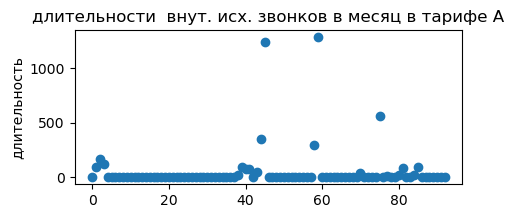

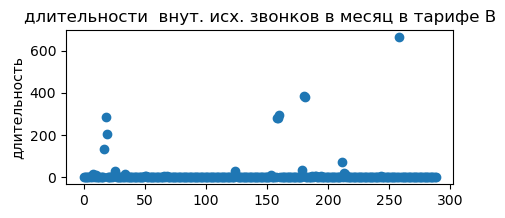

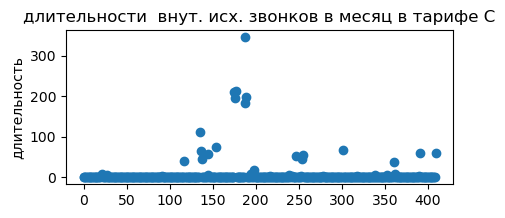

In [96]:
#Построим точечный график внутрених исходящих звонков за каждый месяц в разрезе по тарифам
plt.figure(figsize=(5,2))
x_values = pd.Series(range(0,len(dt2.query('tariff_plan == "A"'))))
plt.scatter(x_values, dt2.query('tariff_plan == "A"')['internal_true_min'])
plt.ylabel('длительность')
plt.title('длительности  внут. исх. звонков в месяц в тарифе А')
plt.show()

plt.figure(figsize=(5,2))
x_values = pd.Series(range(0,len(dt2.query('tariff_plan == "B"'))))
plt.scatter(x_values, dt2.query('tariff_plan == "B"')['internal_true_min'])
plt.ylabel('длительность')
plt.title('длительности  внут. исх. звонков в месяц в тарифе В')
plt.show()

plt.figure(figsize=(5,2))
x_values = pd.Series(range(0,len(dt2.query('tariff_plan == "C"'))))
plt.scatter(x_values, dt2.query('tariff_plan == "C"')['internal_true_min'])
plt.ylabel('длительность')
plt.title('длительности  внут. исх. звонков в месяц в тарифе С')
plt.show()

видно что большинство клиентов мало используют внутрение исходящие звонки на всех тарифах 

компании нужно пересмотреть тарифы, тк большинство клиентов не пользуются внутреними звонками, похоже они в основном используют внешние вызовы

проверим длительность внешних звонков по тарифам в месяц 

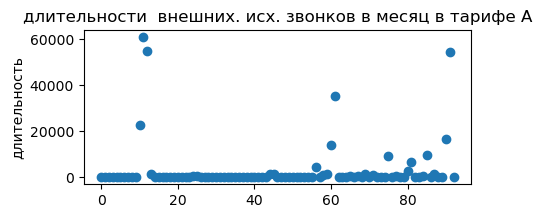

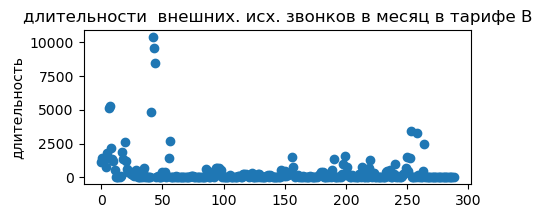

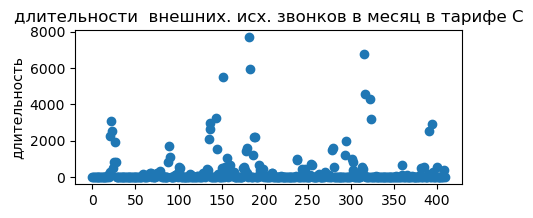

In [97]:
#Построим точечный график внутрених исходящих звонков за каждый месяц в разрезе по тарифам
plt.figure(figsize=(5,2))
x_values = pd.Series(range(0,len(dt2.query('tariff_plan == "A"'))))
plt.scatter(x_values, dt2.query('tariff_plan == "A"')['internal_false_min'])
plt.ylabel('длительность')
plt.title('длительности  внешних. исх. звонков в месяц в тарифе А')
plt.show()

plt.figure(figsize=(5,2))
x_values = pd.Series(range(0,len(dt2.query('tariff_plan == "B"'))))
plt.scatter(x_values, dt2.query('tariff_plan == "B"')['internal_false_min'])
plt.ylabel('длительность')
plt.title('длительности  внешних. исх. звонков в месяц в тарифе В')
plt.show()

plt.figure(figsize=(5,2))
x_values = pd.Series(range(0,len(dt2.query('tariff_plan == "C"'))))
plt.scatter(x_values, dt2.query('tariff_plan == "C"')['internal_false_min'])
plt.ylabel('длительность')
plt.title('длительности  внешних. исх. звонков в месяц в тарифе С')
plt.show()

также большинство клиентом совершают не длительные звонки в месяц
значит для большинства будут оптимальны тариф С

# проверка статистических гипотез

- гипотеза 1

нулевая гипотеза: средние значения совокупностей total_pay и optimal_pay равны. 

альтернативную гипотеза: среднее значение total_pay больше среднего значения optimal_pay.

In [98]:
alpha = 0.05

results = st.ttest_ind(dt3['total_pay'], dt3['optimal_pay'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 3.1807587512795606e-08
Отвергаем нулевую гипотезу


Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. 
Есть основания говорить, что клиенты раньше тратили больше чем с оптимальными тарифами

- гипотеза 2

Нулевая гипотеза: Статистически значимых различий в размере прибыли компании если пользователи с неоптимальными тафрифами уйдут и в размере прибыли компании если мы переведем их на оптимальный тариф - нет

Альтернативная гипотеза: Статистически значимые различия в размере прибыли компании - есть

In [99]:
alpha = 0.05

results = st.ttest_ind(dt_witout['total_pay'], dt2['optimal_pay'], equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.9826174422487534e-31
Отвергаем нулевую гипотезу


Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что значимые различия в размере прибыли компании если пользователи с неоптимальными тафрифами уйдут и в размере прибыли компании если мы переведем их на оптимальный тариф - есть. Исходя из данных выше прибыль компании если клиенты уйдут будет мешьше, нежили если перевести клиентов на оптимальные тарифы

Вывод:

Провели иследование данных:

- Нашли клиентов с неоптимальными тарифами
- почти 50% клиентов переплачивают по тарифам
- предложили клиентам оптимальные тарифы исходя из их нынешних трат
- посчитали общую прибыль компании , прибыль компании по месяцам, прибыль компании с разбивкой по тарифам по месяцам.
- посчитали длительность звонков по месяцам, большая часть клиентов не израсходует внутренние исходящие минуты, которые входят в тариф, а в основном используют внешние исходящие звонки - для них будут оптимальны тариф С
- выяснили, что если перевести всех клиентов на оптимальные тарифы, компания потеряет в прибыли 20-25% 
- если не переводить и клиенты уйдут, то компания потеряет до 40% прибыли
- можно предложить перевести 40% клиентов на оптимальные тарифы, которые больше всего переплачивали - так компания сохранит клиентов, понесет меньше убытков в будущем - потери составят около 15% прибыли

Провели Статистические тесты:

- клиенты раньше тратили больше чем могли бы тратить с оптимальными тарифами
- есть статистически значимые различия в размере прибыли компании если клиенты уйдут и если перевести клиентов на оптимальные тарифы

 



Также компании нужно следить за количеством операторов, тк у одного клиента вероятно под одним аккаунтом совершаются звонки несколькими сотрудниками, тк присутствуют аномально длительные разговоры


<div class="alert alert-info">

ссылка на презентацию

https://disk.yandex.ru/i/6WULUeAqv7c11A